# 0. Purpose / Method

### The purpose of this notebook is to showcase a potential content-based Spotify playlist generator, using cosine similarity and K-Means clustering. 

### Input - 1 song; Output - N most similar songs (ranked)

### Bulk of the recommendation is done by checking cosine similarity between the input song and every other song.

### Finding: While K-Means is superfluous in terms of the recommendations themselves, it does help speed up the recommendation process significantly. By limiting the cos. similarity checking to only songs from the input song's cluster, you get identical recommendations but with faster computation.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv


# 1. EDA / Feature selection

In [2]:
df = pd.read_csv('/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv')

df.loc[df.loc[:,'genre']=='Rap','genre'] = 'Hip-Hop'

df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

### To utilize categorical values such as genre, mode, key and time signature, we will combine them into 2 continuous variables using PCA.

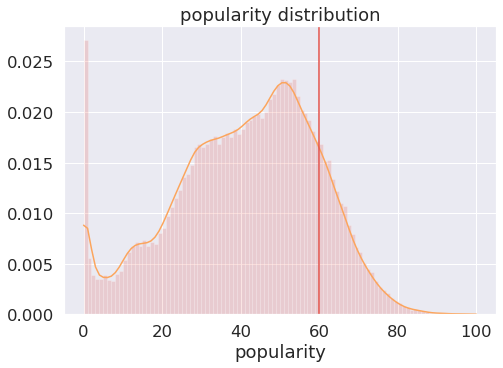

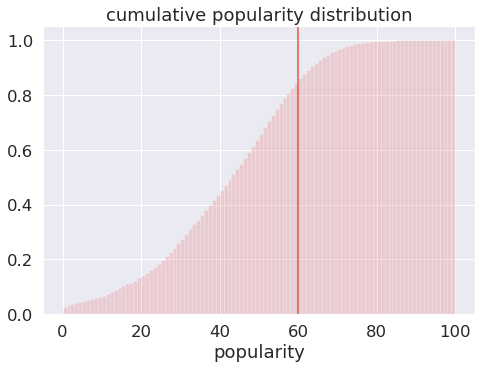

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

import scipy.stats as st

data = df.loc[:, 'popularity'].values

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

kde_xs = np.linspace(min(data), max(data), 100)
kde = st.gaussian_kde(data)

ax.hist(
    data,
    alpha=0.2,
    bins=100,
    density=True
)
ax.plot(
    kde_xs, 
    kde.pdf(kde_xs)
)

ax.axvline(x=60)

plt.xlabel('popularity')
plt.title('popularity distribution')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    data,
    alpha=0.2,
    bins=100,
    density=True,
    cumulative=True
)
ax.axvline(x=60)

plt.xlabel('popularity')
plt.title('cumulative popularity distribution')
plt.show()

In [4]:
df = df.loc[df.loc[:, 'popularity']>= 60, :]

df.shape

(36454, 18)

### We are only using songs with popularity >= 60, to speed up computation and increase relevance.

0 popularity
1 acousticness
2 danceability
3 duration_ms
4 energy
5 instrumentalness
6 liveness
7 loudness
8 speechiness
9 tempo
10 valence
11 pca_1
12 pca_2


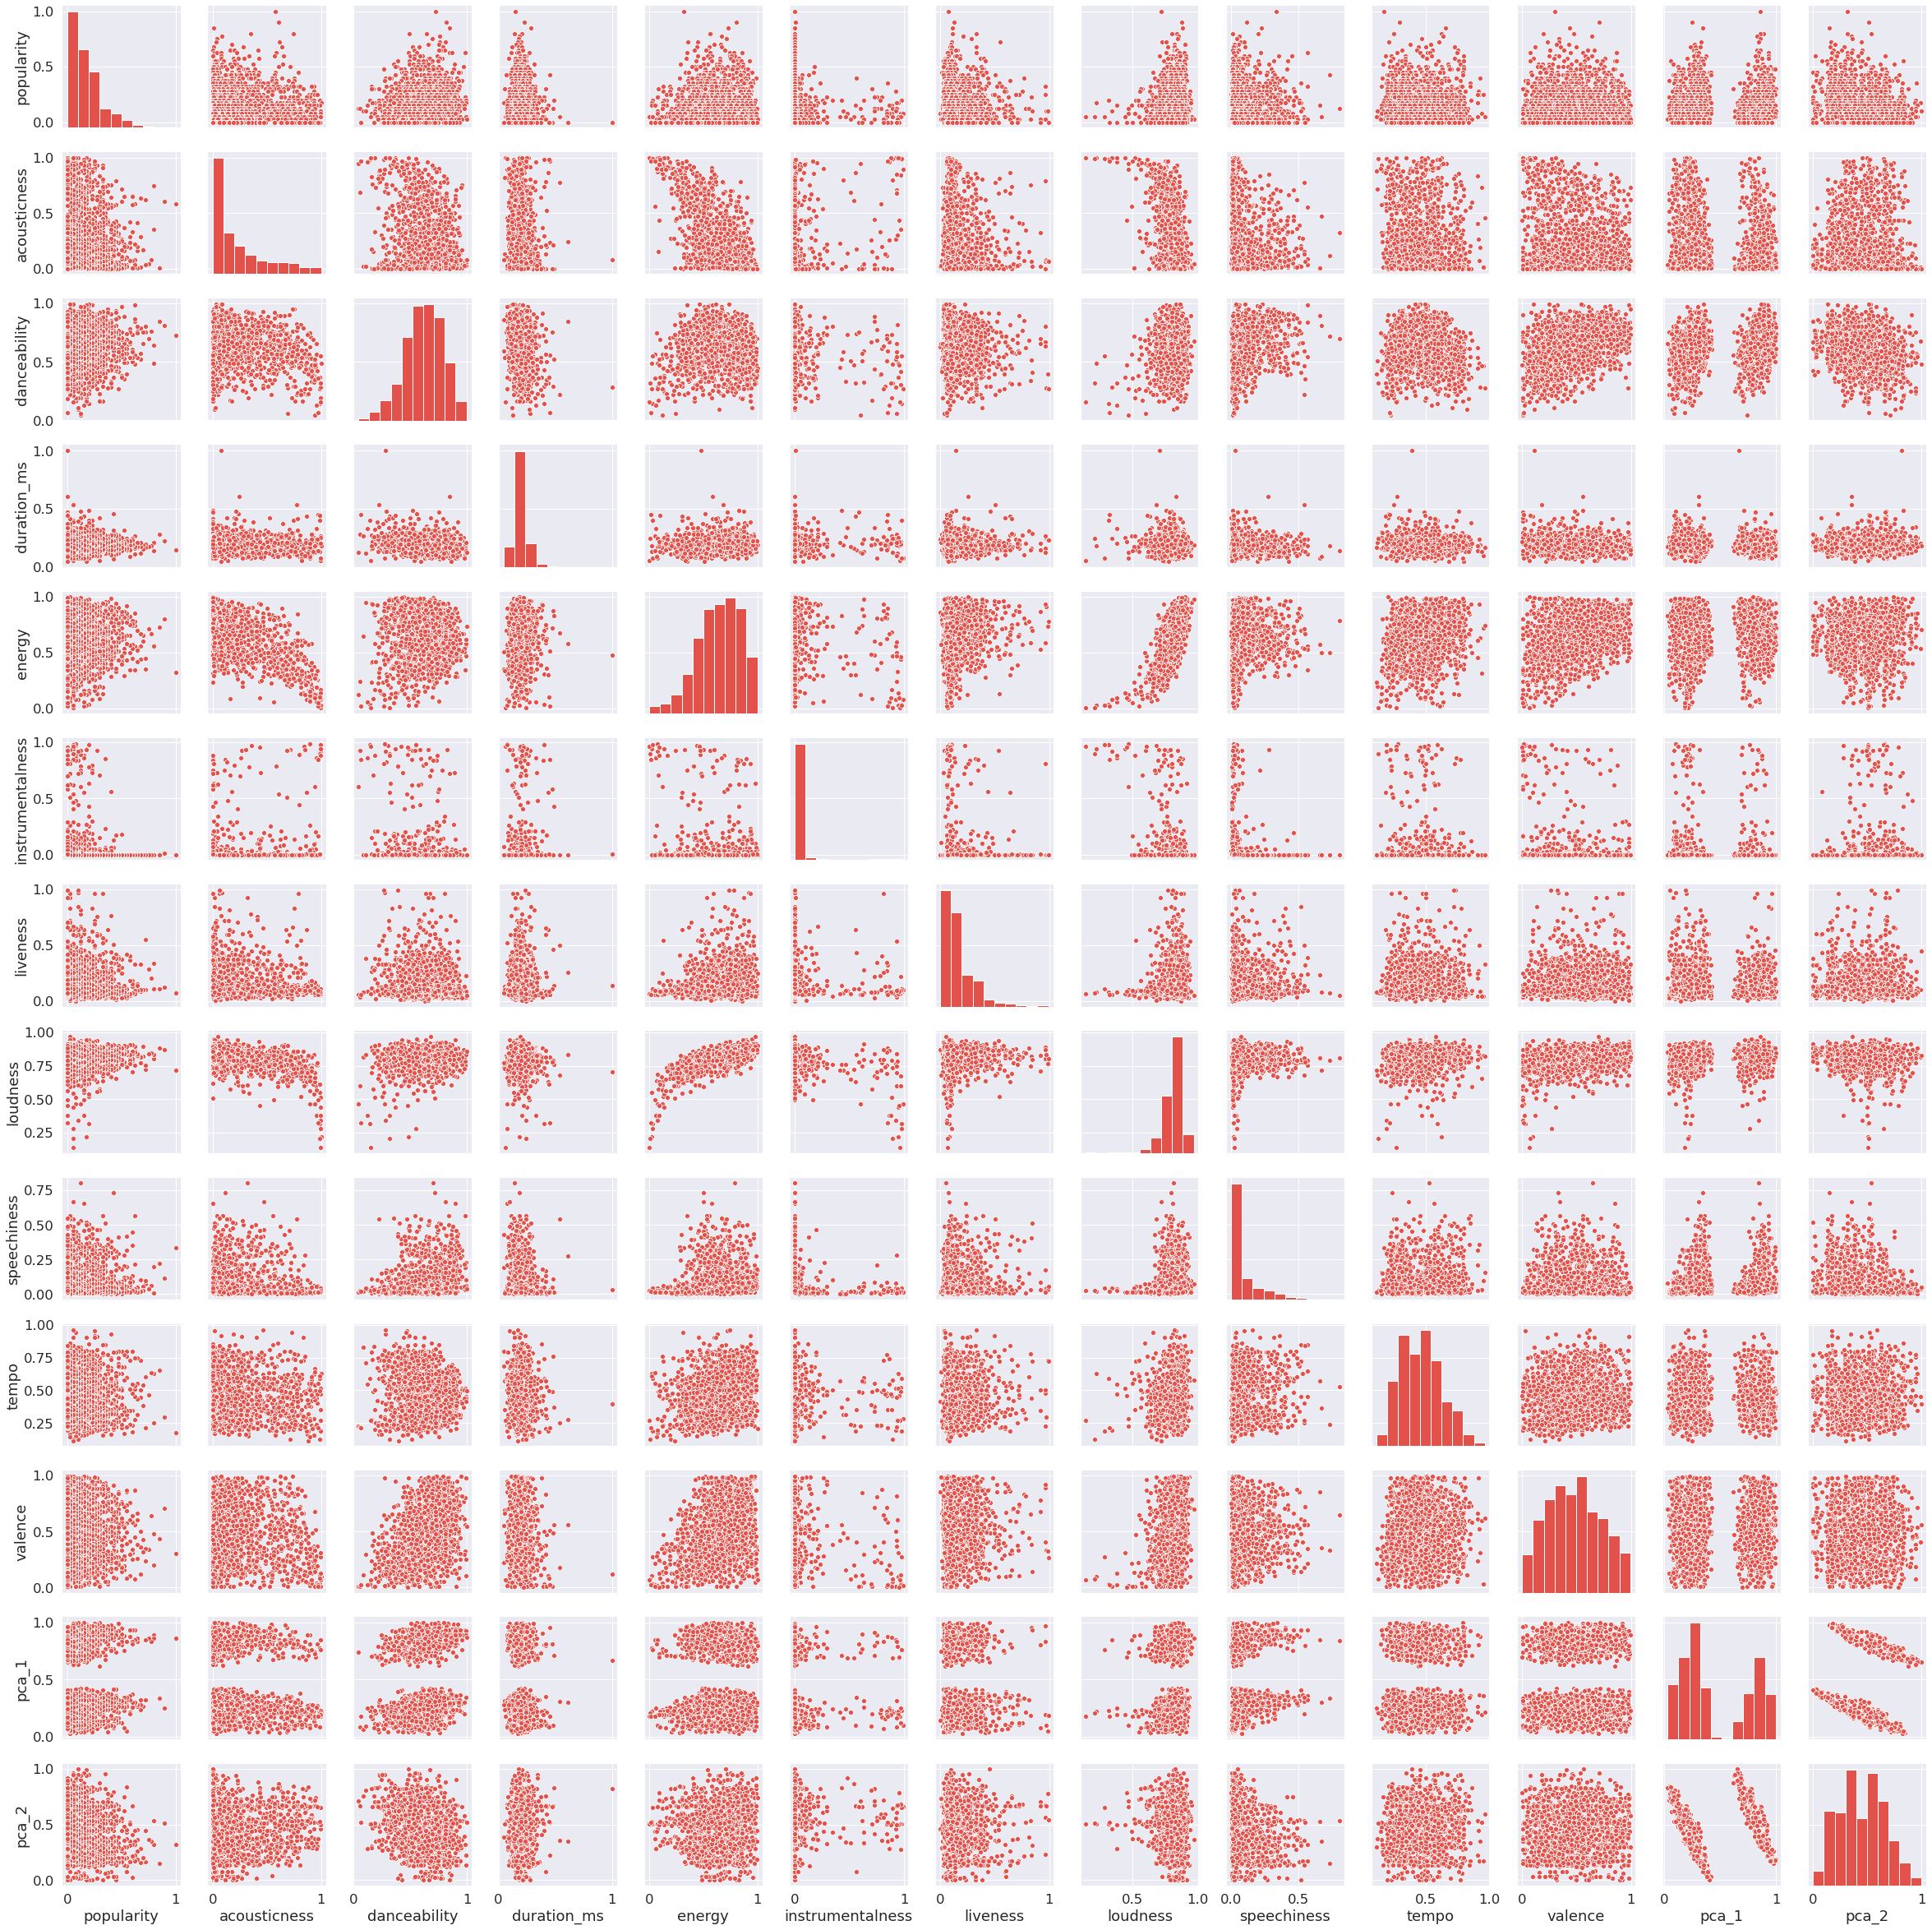

In [5]:
from sklearn.decomposition import PCA
import seaborn as sns

num_components = 2
cols = ['artist_name','track_name','track_id']

def prepro(df, cols, num_components):

    dummies = pd.get_dummies(df.loc[:, ~df.columns.isin(cols)])
    
    merged = pd.merge(df.loc[:, cols], dummies, left_index=True, right_index=True)
    
    merged = merged.groupby(cols).max()
    
    genres = merged.loc[:, [i for i in merged.columns if i.startswith('genre')]]
            
    x = merged.iloc[:, 11:]

    pca = PCA(n_components=num_components)
    x_pca = pca.fit_transform(x)
    
    merged = merged.iloc[:, :11]
    
    for i in range(num_components):
        merged.loc[:, f'pca_{i+1}'] = x_pca[:, i]
        
    for col in merged.columns:
        mn, mx = min(merged.loc[:, col]), max(merged.loc[:, col])
        
        merged.loc[:, col] -= mn
        merged.loc[:, col] /= (mx - mn)

    
    return merged, genres
    
    
tmp, genres = prepro(df, cols, num_components)

tmp = tmp.sort_values(['popularity'], ascending=False)

for i, col in enumerate(tmp.columns):
    print(i, col)

    
sns.pairplot(tmp.iloc[::10,:])
plt.show()

In [6]:
for i in range(1000):
    print(i, tmp.iloc[i, :].name)

0 ('Ariana Grande', '7 rings', '14msK75pk3pA33pzPVNtBF')
1 ('Ariana Grande', "break up with your girlfriend, i'm bored", '4kV4N9D1iKVxx1KLvtTpjS')
2 ('Post Malone', 'Wow.', '6MWtB6iiXyIwun0YzU6DFP')
3 ('Daddy Yankee', 'Con Calma', '5w9c2J52mkdntKOmRLeM2m')
4 ('Marshmello', 'Happier', '2dpaYNEQHiRxtZbfNsse99')
5 ('Pedro Capó', 'Calma - Remix', '5iwz1NiezX7WWjnCgY5TH4')
6 ('Post Malone', 'Sunflower - Spider-Man: Into the Spider-Verse', '3KkXRkHbMCARz0aVfEt68P')
7 ('Halsey', 'Without Me', '5p7ujcrUXASCNwRaWNHR1C')
8 ('Sam Smith', 'Dancing With A Stranger (with Normani)', '6Qs4SXO9dwPj5GKvVOv8Ki')
9 ('Ava Max', 'Sweet but Psycho', '25sgk305KZfyuqVBQIahim')
10 ('Anuel Aa', 'Secreto', '5W83ErFkO3aKAIS1WMi6u0')
11 ('DJ Snake', 'Taki Taki (with Selena Gomez, Ozuna & Cardi B)', '4w8niZpiMy6qz1mntFA5uM')
12 ('J. Cole', 'MIDDLE CHILD', '2JvzF1RMd7lE3KmFlsyZD8')
13 ('Lady Gaga', 'Shallow', '2VxeLyX666F8uXCJ0dZF8B')
14 ('Paulo Londra', 'Adan y Eva', '6FyRXC8tJUh863JCkyWqtk')
15 ('Ozuna', 'Baila Bai

# 2. Clustering

### We are going to use K-Means clustering, on all parameters previously outlined.

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23
k=24
k=25
k=26
k=27
k=28
k=29
k=30


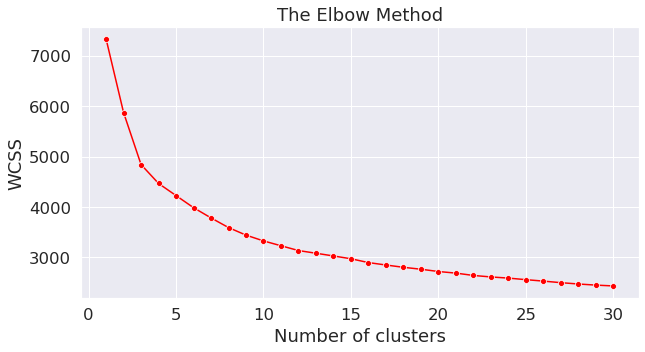

In [7]:
# kmeans
# input: 1 song
# output: which cluster it came from (charts), and similar songs from the cluster (cosine similarity ranking top 10 similar from the same cluster)

from sklearn.cluster import KMeans

num_clust = 30

wcss = []

for i in range(1, num_clust+1):
    print(f'k={i}')
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(tmp)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))

sns.lineplot(range(1, num_clust+1), wcss,marker='o',color='red')

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### We choose k = 15, it seems a good approximation of optimal # of clusters.

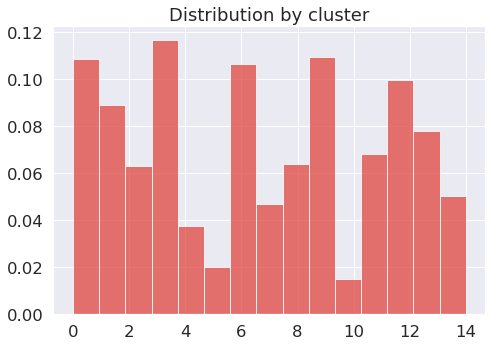

In [8]:
num_clust = 15

kmeans = KMeans(n_clusters = num_clust, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(tmp)

tmp.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=num_clust,
    density=True,
    alpha=0.8
)

plt.title('Distribution by cluster')
plt.show()

In [9]:
col_nums = {}

for i, c in enumerate(tmp.columns[:-1]):
    col_nums[c] = i
    
col_nums

# kmeans.cluster_centers_.shape (n_clusters, n_features)

{'popularity': 0,
 'acousticness': 1,
 'danceability': 2,
 'duration_ms': 3,
 'energy': 4,
 'instrumentalness': 5,
 'liveness': 6,
 'loudness': 7,
 'speechiness': 8,
 'tempo': 9,
 'valence': 10,
 'pca_1': 11,
 'pca_2': 12}

# 3. Cosine similarity recommendation

### Below is how we define cosine similarity. Lower value = more similar.

![](https://neo4j.com/docs/graph-algorithms/current/images/cosine-similarity.png)

### Recommendation logic is simple: in a loop, check similarity score between the input song and every other song in that cluster. Then rank output in ascending order by similarity value.

## 3.1 Creating a playlist around Travis Scott's SICKO MODE

![](https://i.ebayimg.com/images/g/qhUAAOSwOvRbYY8D/s-l300.jpg)

Travis Scott - SICKO MODE
most similar songs:
    Travis Scott - SICKO MODE
    Ariana Grande - bad idea
    Migos - Walk It Talk It
    Travis Scott - goosebumps
    BlocBoy JB - Look Alive (feat. Drake)
    21 Savage - a lot
    Future - First Off (feat. Travis Scott)
    Ava Max - Sweet but Psycho
    Tory Lanez - TAlk tO Me (with Rich The Kid feat. Lil Wayne) - Remix
    Calvin Harris - Promises (with Sam Smith)


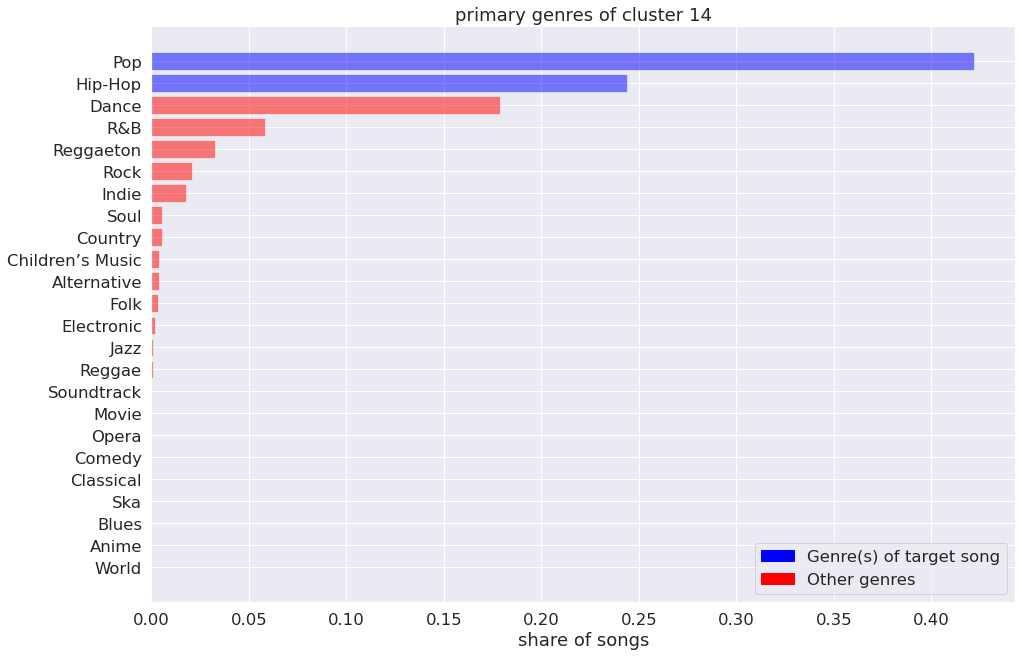

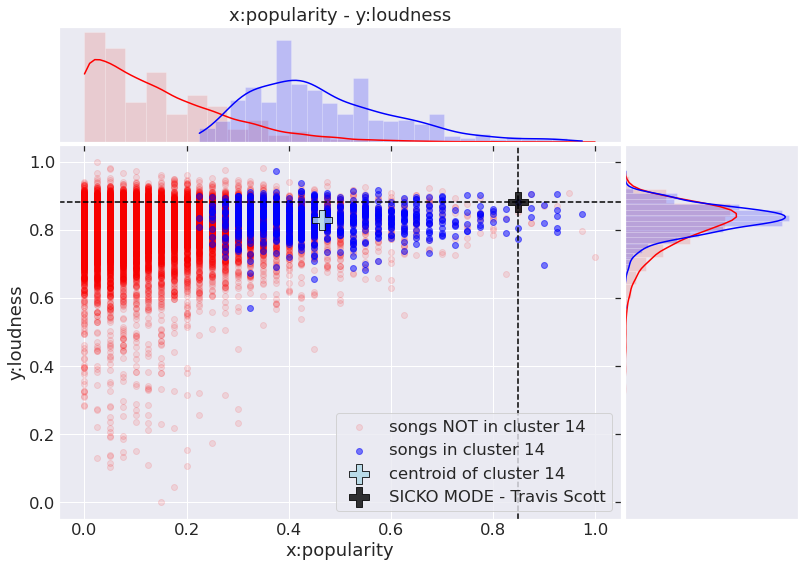

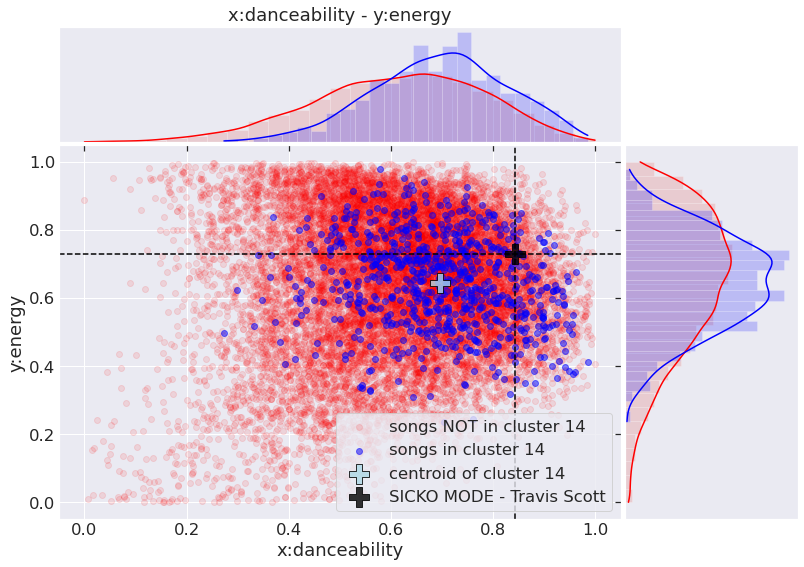

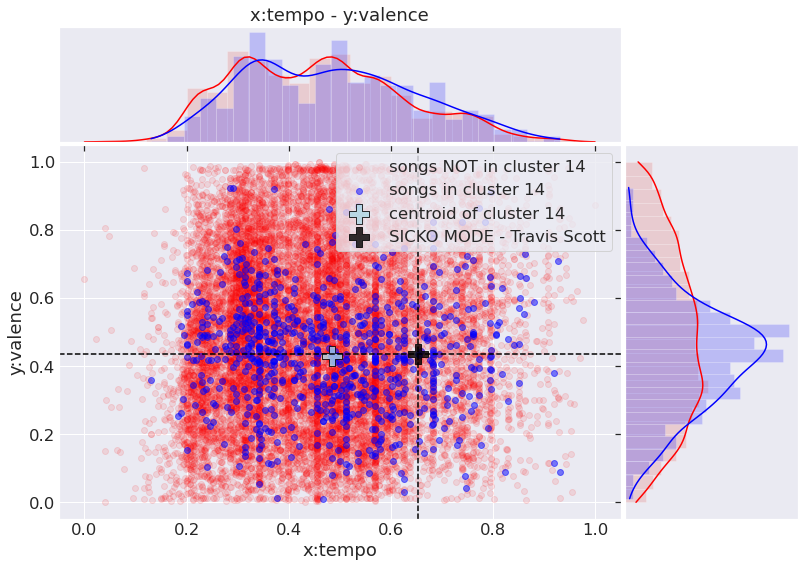

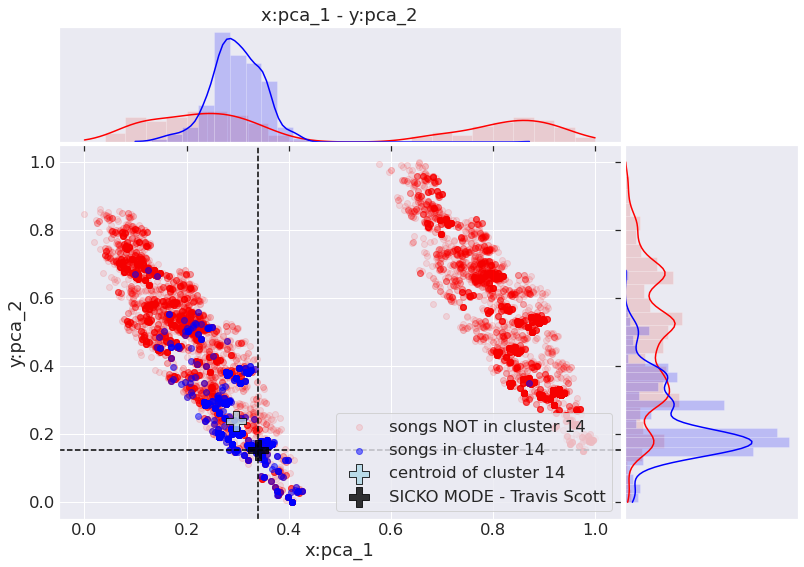

In [10]:
# cosine similarity

from scipy import spatial
import matplotlib.patches as mpatches
from matplotlib import transforms


inds = {
    'index': 20
}

for i in inds.values():
    print(f'{tmp.iloc[i, :].name[0]} - {tmp.iloc[i, :].name[1]}')
    
pairs = [
    ['popularity', 'loudness'],
    ['danceability', 'energy'],
    ['tempo', 'valence'],
    ['pca_1', 'pca_2']
]

    
def charts(inds, tmp, genres):
    
    plotDf = tmp
        
    target_ind = inds['index']
    target_vals = tmp.iloc[target_ind, :]
    
    genres = genres.reindex(tmp.index)
    
    tmp_genres = genres.iloc[target_ind, :]
    
    genres.loc[:, 'cluster'] = tmp.loc[:, 'cluster']

    clust = tmp['cluster'].iloc[target_ind]
    tmp = tmp.loc[tmp.loc[:, 'cluster'] == clust, :]
    
    tmp.loc[:, 'index'] = 0

    for i in range(len(tmp)):
        tmp.loc[:, 'index'].iloc[i] = spatial.distance.cosine(target_vals, tmp.iloc[i, :-1])

    print('most similar songs:')
    head = tmp.sort_values(['index']).head(10)
    
    for i in head.index:
        print(f'    {i[0]} - {i[1]}')
                
    genres = genres.loc[genres.loc[:,'cluster']==clust,:].groupby(['cluster']).sum()
    
    genres = genres.T
    
    genres.loc[:, 'target'] = tmp_genres.T
    
    genres.columns = ['cluster', 'target']
    
    genres = genres.sort_values(['cluster'], ascending = True)
    
    genres.loc[:, 'cluster'] /= genres.loc[:, 'cluster'].sum()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])

    ax.barh(
        [i.split('_')[1] for i in genres.index],
        genres.loc[:, 'cluster'],
        color = ['blue' if i == 1 else 'red' for i in genres.loc[:, 'target']],
        alpha = 0.5,
        label=f''
    )

    plt.title(f'primary genres of cluster {clust}')
    plt.xlabel(f'share of songs')
    plt.ylabel(f'')
    
    red_patch = mpatches.Patch(color='red', label=f'Other genres')
    blue_patch = mpatches.Patch(color='blue', label=f'Genre(s) of target song')
    plt.legend(handles=[blue_patch, red_patch], loc='lower right')
    plt.show()


    for p in pairs:
                
        # the random data
        x = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[0]]
        y = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[1]]
        
        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005


        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(figsize=(12, 8))

        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy = plt.axes(rect_histy)
        ax_histy.tick_params(direction='in', labelleft=False)

        # the scatter plot:
        ax_scatter.scatter(x, y,
            color = 'red',
            alpha = 0.1,
            label=f'songs NOT in cluster {clust}'
        )
        
        def get_kde(data):
        
            kde_xs = np.linspace(min(data), max(data), 100)
            kde = st.gaussian_kde(data)
            
            return kde_xs, kde
        
        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)


        ax_histx.hist(x, 
                      bins=25, 
                      alpha=0.2, 
                      density=True
        )
        ax_histy.hist(y, 
                      bins=25, 
                      alpha=0.2, 
                      density=True, 
                      orientation='horizontal'
        )
        
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='red'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='red', transform = rot + base
        )
        
        x = tmp.loc[tmp.loc[:, 'cluster']==clust, p[0]]
        y = tmp.loc[tmp.loc[:, 'cluster']==clust, p[1]]
        
        ax_scatter.scatter(x, y, 
            color = 'blue',
            alpha = 0.5,
            label=f'songs in cluster {clust}'
        )        
        ax_scatter.scatter(
            kmeans.cluster_centers_[clust, col_nums[p[0]]],
            kmeans.cluster_centers_[clust, col_nums[p[1]]],
            color = 'lightblue',
            edgecolors = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'centroid of cluster {clust}'
        )
        ax_scatter.scatter(
            target_vals[col_nums[p[0]]],
            target_vals[col_nums[p[1]]],
            color = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'{head.index[0][1]} - {head.index[0][0]}'
        )
        ax_scatter.legend()
                
        ax_scatter.axvline(x=target_vals[col_nums[p[0]]], color='black', linestyle='dashed')
        ax_scatter.axhline(y=target_vals[col_nums[p[1]]], color='black', linestyle='dashed')

        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)

        ax_histx.hist(x, bins=25, alpha=0.2, density=True, color='blue')
        ax_histy.hist(y, bins=25, alpha=0.2, density=True, color='blue', orientation='horizontal')
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='blue'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='blue', transform = rot + base
        )
        
        ax_histx.axes.xaxis.set_visible(False)
        ax_histx.axes.yaxis.set_visible(False)
        ax_histy.axes.xaxis.set_visible(False)
        ax_histy.axes.yaxis.set_visible(False)
        

        ax_histx.set_title(f'x:{p[0]} - y:{p[1]}')
        ax_scatter.set_xlabel(f'x:{p[0]}')
        ax_scatter.set_ylabel(f'y:{p[1]}')

        plt.show()

    
charts(inds, tmp, genres)

## 3.2 Creating a playlist around Radiohead's Creep

![](https://upload.wikimedia.org/wikipedia/en/9/9d/Radiohead_original_creep_cover.jpg)

Radiohead - Creep
most similar songs:
    Radiohead - Creep
    Tom Walker - Leave a Light On
    Radiohead - Karma Police
    Radiohead - High And Dry
    Pixies - Where Is My Mind?
    Imagine Dragons - Zero - From the Original Motion Picture "Ralph Breaks The Internet"
    Chicago - If You Leave Me Now - Remastered
    December Avenue - Kung 'Di Rin Lang Ikaw
    Guns N' Roses - Don't Cry (Original)
    Radiohead - No Surprises


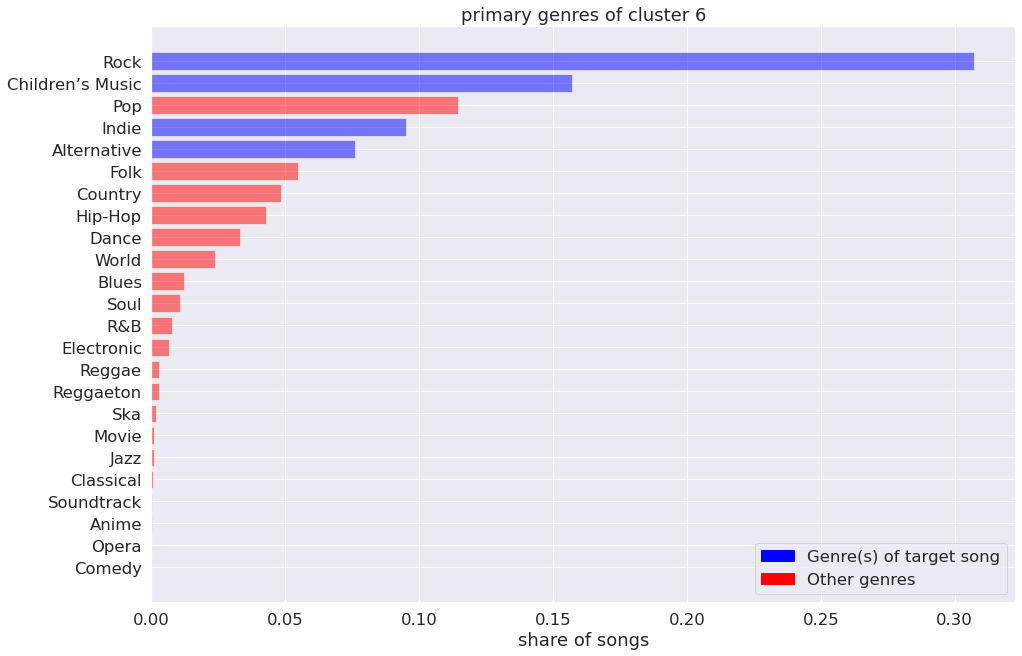

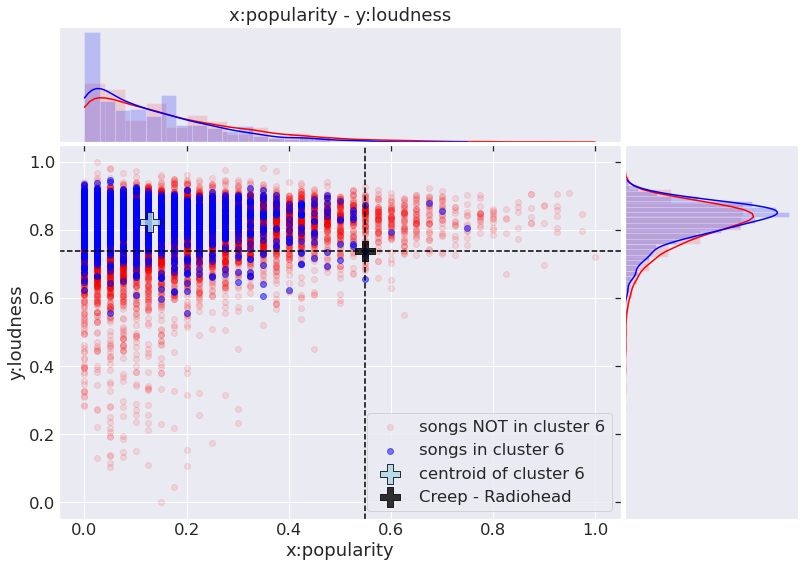

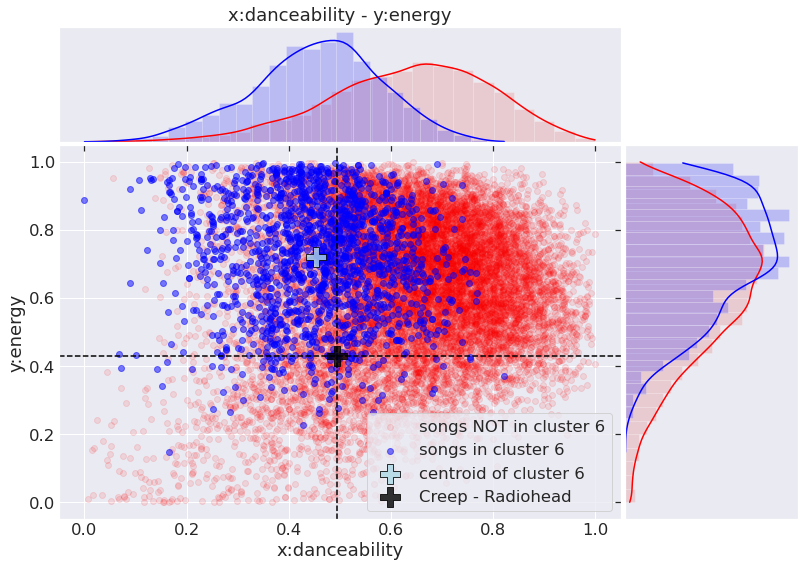

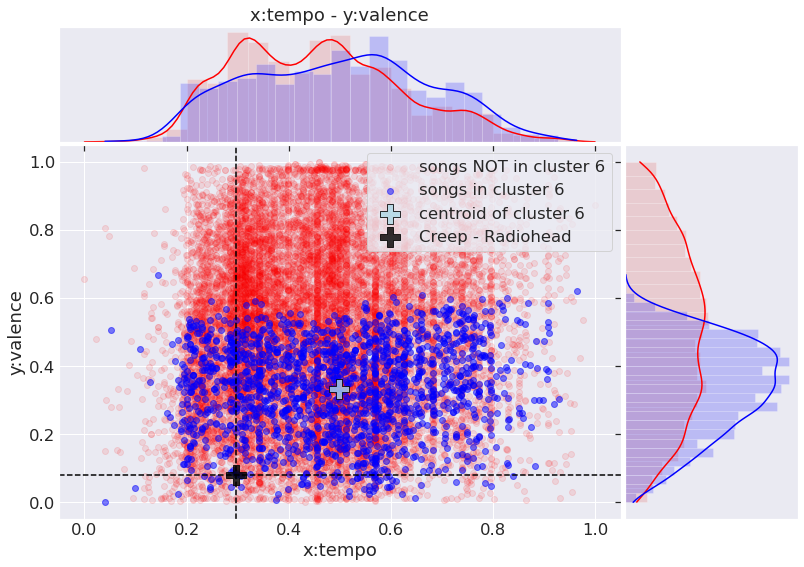

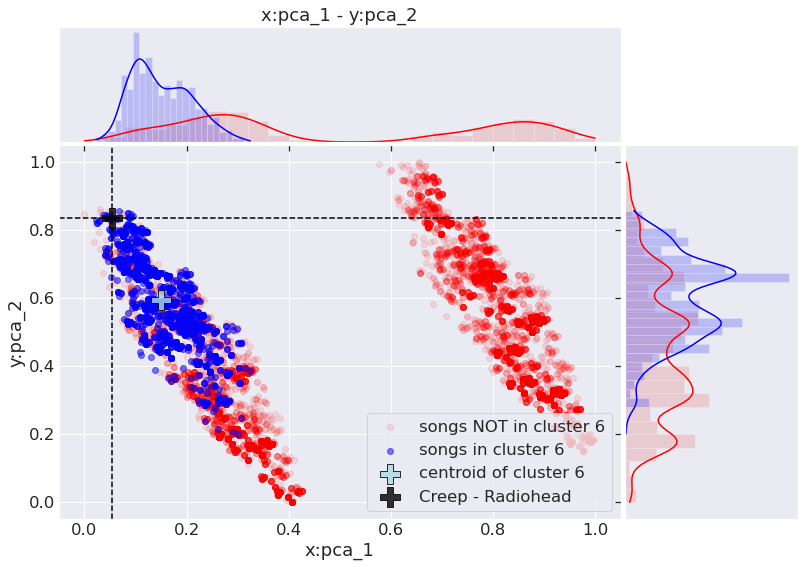

In [11]:
inds = {
    'index': 370
}

for i in inds.values():
    print(f'{tmp.iloc[i, :].name[0]} - {tmp.iloc[i, :].name[1]}')
    
    
charts(inds, tmp, genres)

## 3.3 Creating a playlist around John Lennon's Imagine

![](https://upload.wikimedia.org/wikipedia/en/6/69/ImagineCover.jpg)

John Lennon - Imagine - Remastered
most similar songs:
    John Lennon - Imagine - Remastered
    Ray LaMontagne - Such A Simple Thing
    Brett Young - Mercy
    Queen - Love Of My Life - Remastered 2011
    Elvis Presley - Can't Help Falling in Love
    The Beatles - Yesterday - Remastered 2009
    Elton John - Your Song
    Plain White T's - Hey There Delilah
    Dermot Kennedy - For Island Fires and Family
    James Blunt - Goodbye My Lover


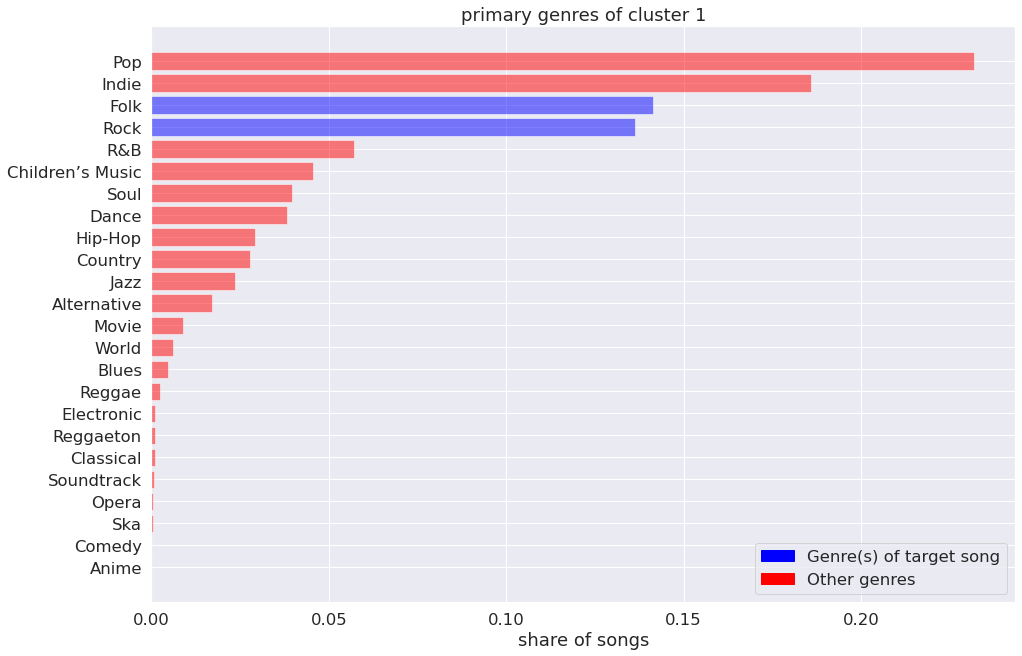

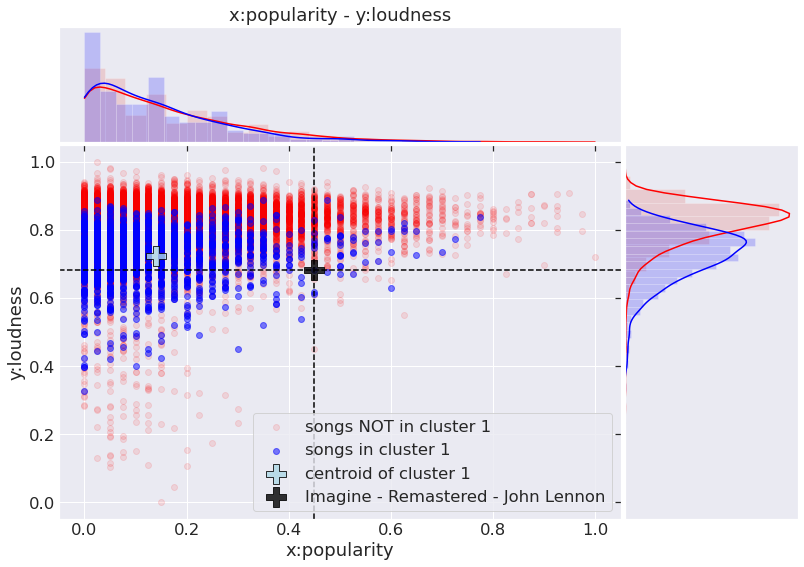

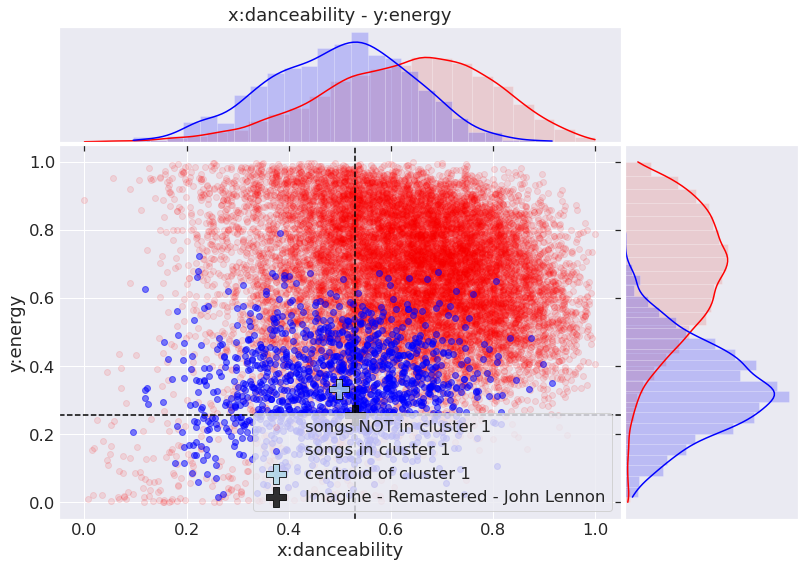

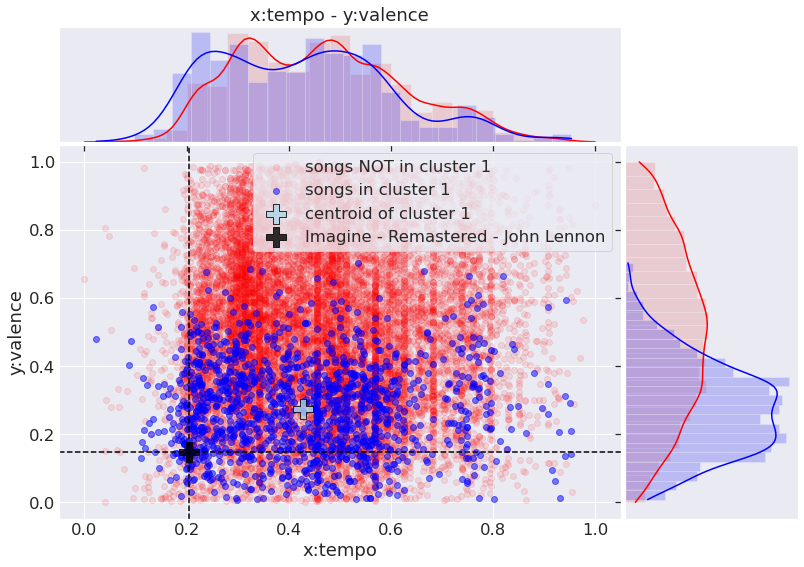

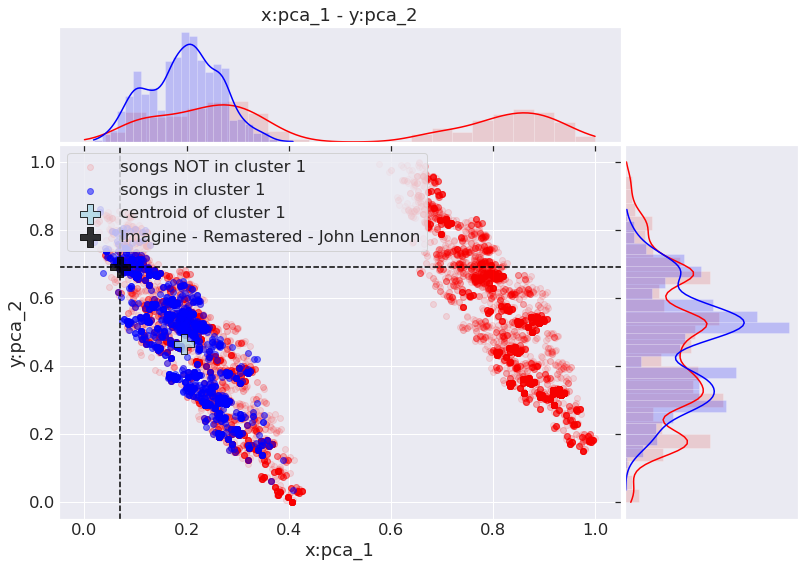

In [12]:
inds = {
    'index': 877
}

for i in inds.values():
    print(f'{tmp.iloc[i, :].name[0]} - {tmp.iloc[i, :].name[1]}')
    

    
charts(inds, tmp, genres)

# 4. Conclusion

### Cosine similarity works reasonably well in identifying similar songs, that adds value beyond simple genre filtering. In the real world, this combined with a collaborative filtering method could produce a reasonable recommendation system for songs. 